### Autres Méthodes de réductions : TCA (Tensor PCA) et UMAP
### Tensor Decomposition or Factorization

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os 
os.environ["ENV"]="LOCAL"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../store_order_service_account"
#print(os.environ) 
os.chdir("/Users/gnabeyeuemmanuel/Desktop/demandEstimate/demand-service")

### Useful Library

In [3]:
import os
import sys
import sys; 
sys.path.insert(0, '..')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Data processing
import pandas as pd
import numpy as np
# Model performance evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from sklearn import metrics

from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
from sklearn.cluster import KMeans
#import pandasgui

%matplotlib inline
import google.cloud.secretmanager as secretmanager

# from utils.utility_fct import get_table_sql,cross_product


from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

import time
import datetime
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
#from french_holidays import get_french_holiday_calendar


from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from datetime import datetime, timedelta

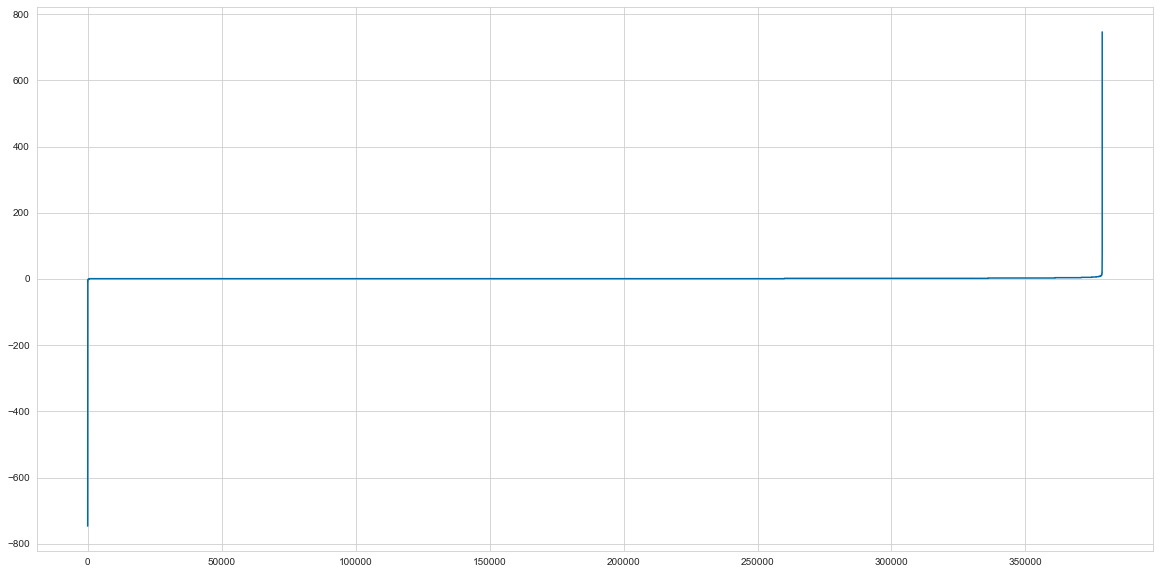

In [4]:
dta=pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/Data/nom-fichier.csv')
plt.plot(dta['product_count'])

### Load and Plot the time series dataset

In [5]:
series1 = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/Data/demandes.csv', header=0) #index_col=0 
series2 = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/Data/products_movements.csv', header=0) #.iloc[20:,:] 
series1['product_count']=series1['product_count']
series1=series1[['store_id','product_id','product_count','time']]
series2=series2[['store_id','product_id','start_date', 'end_date']]
series1.head() 

,store_id,product_id,product_count,time
0,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-03
1,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-05
2,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,2.0,2022-02-09
3,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-10
4,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,2.0,2022-02-13


In [6]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df1=pd.DataFrame() 
    #début à partir du 1er janvier 2022   .strftime('%Y-%m-%d')
    ref=datetime(2022,1,1)
    indexNames = df[df['end_date'] < ref].index
    df.drop(indexNames , inplace=True)
    for i in df.index:
        if df['start_date'][i] < ref:
            df['start_date'][i] = ref
            
    #Dates intermédiaires sur la présence des produits dans le magassin
    df["date"] = df.apply(lambda x: pd.date_range(x.start_date, x.end_date), axis=1)
    df = df.explode('date').reset_index(drop=True)
    df['date']=df['date'].dt.date
        
    return df

In [7]:
series2['start_date']= pd.to_datetime(series2['start_date'],utc=True).dt.tz_localize(None)
series2['end_date']= pd.to_datetime(series2['end_date'],utc=True).dt.tz_localize(None)

df_pro=preprocess(series2)
df_pro

,store_id,product_id,start_date,end_date,date
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586,2022-01-01
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586,2022-01-02
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586,2022-01-03
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586,2022-01-04
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586,2022-01-05
...,...,...,...,...,...
1724230,62b1e32b1b95a10016871dab,6306541e78a7290011983719,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586,2022-09-04
1724231,62b1e32b1b95a10016871dab,6306541e78a7290011983719,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586,2022-09-05
1724232,62b1e32b1b95a10016871dab,6306541e78a7290011983719,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586,2022-09-06
1724233,62b1e32b1b95a10016871dab,6306541e78a7290011983719,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586,2022-09-07


In [8]:
series1['date'] = pd.to_datetime(series1.time).dt.date
series3=series1.merge(df_pro, how='right', on=['date','store_id','product_id']).fillna({'product_count':0})
series3

,store_id,product_id,product_count,time,date,start_date,end_date
0,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,NaN,2022-01-01,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586
1,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,NaN,2022-01-02,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586
2,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,NaN,2022-01-03,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586
3,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,NaN,2022-01-04,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586
4,5d5d24216115b3000435fa24,5cebfa8d0b259700045dc8a9,0.0,NaN,2022-01-05,2022-01-01 00:00:00.000,2022-09-08 08:11:22.414586
...,...,...,...,...,...,...,...
1724230,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-04,2022-09-04,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586
1724231,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-05,2022-09-05,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586
1724232,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-06,2022-09-06,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586
1724233,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-07,2022-09-07,2022-09-01 04:24:15.213,2022-09-08 08:11:22.414586


In [9]:
df=series3.dropna()
df.drop(df.columns[[4, 5]], axis = 1, inplace = True) #df.drop(df.loc[:, 'start_date ':'end_date '].columns, axis = 1) 
df

,store_id,product_id,product_count,time,end_date
48581,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-03,2022-09-08 08:11:22.414586
48583,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-05,2022-09-08 08:11:22.414586
48587,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,2.0,2022-02-09,2022-09-08 08:11:22.414586
48588,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,1.0,2022-02-10,2022-09-08 08:11:22.414586
48591,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,2.0,2022-02-13,2022-09-08 08:11:22.414586
...,...,...,...,...,...
1724223,62b1e32b1b95a10016871dab,6306515f78a729001198361a,2.0,2022-09-05,2022-09-08 08:11:22.414586
1724230,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-04,2022-09-08 08:11:22.414586
1724231,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-05,2022-09-08 08:11:22.414586
1724232,62b1e32b1b95a10016871dab,6306541e78a7290011983719,1.0,2022-09-06,2022-09-08 08:11:22.414586


#### création d'une matrice avec une ligne par pas de temps et une colonne par produit/magasin

In [10]:
timestep_product_store =pd.pivot_table(df, values='product_count', index=['time'],
            columns=['product_id', 'store_id'], 
            aggfunc=np.sum) #, fill_value=0) # nan ou fillna= moyenne de la colonne

In [11]:
# fillna() On = 'average quantity of each product over the all data' ie Matrix completion
tab = timestep_product_store.mean()
timestep_product_store = timestep_product_store.fillna(tab)

In [12]:
a=timestep_product_store.iloc[100,:].unstack().fillna(0).to_numpy().shape
b=len(timestep_product_store.index)
c=tuple([b]+list(a))
c

(251, 474, 36)

#### Tensor Decomposition or Factorization

Tensor: A tensor is a multidimensional array. Also known as d-way array, in which "d" stands for "dimensions". Hence, pretty much all of the geometrical data structures we work with are tensors. Up until 
d=2, these tensors have specific names:

1. zero-way tensor: scalar
2. one-way tensor: vector
3. two-way tensor: matrix

**Decomposition:** Decomposition is a process of breaking up into constituent elements. In mathematical analysis, it means factorization of a d-way tensor. In systems science, it consists of finding an optimal partition of a system in terms of its subsystems. In general, decompositions are motivated by a need to obtain a much simpler body of constituents that can best represent a given system 

In [13]:
![Screenshot%202022-08-09%20at%2010.20.18.png](attachment:Screenshot%202022-08-09%20at%2010.20.18.png)

zsh:1: number expected


For PCA, Such decomposition is known as Factor Analysis. The formulation X=AB suffers from a problem called the Rotation Problem. That is, we can insert any nonsingular rotation matrix,Z, in the formulation above , and still end up with the same approximation of X(given that columns of Z have an amplitude of 1).
Hence, if the above formulation is unconstrained, it results in infinitely many combinations of A and B.

Three-way Tensor Decomposition
Three-way decomposition is merely the extension of the two-way decomposition. However, although in the two-way case explicit constraints must be imposed on the problem to result in a unique solution, the high dimensionality of the tensor format comes with blessings — these include possibilities to obtain compact representations, uniqueness of decompositions, flexibility in the choice of constraints, and generality of components that can be identified. In case of three-way decomposition, we have a three-way tensor and we would like to have a model 
M which approximates 
X∈RI×J×K, via a∈RI, b∈RJ, and c∈RK
 such that:

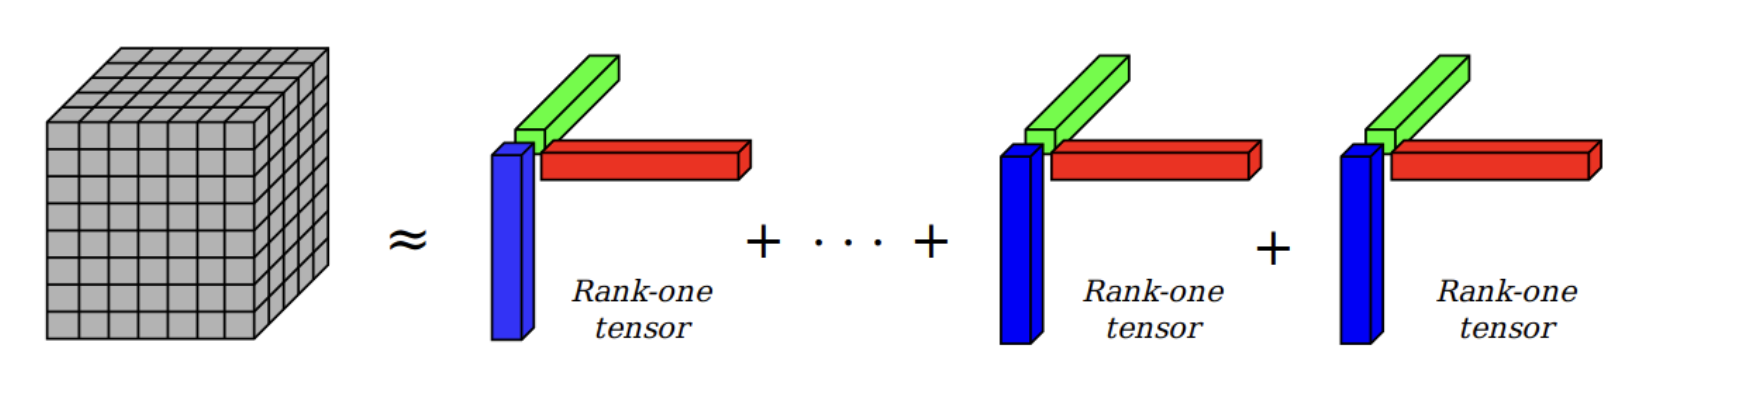

In [14]:
def generate_input(df: pd.DataFrame) -> pd.DataFrame:
    df['time'] = pd.to_datetime(df.time, format='%Y-%m-%d')
    input_data = pd.concat([
            df['time'].dt.date,
            df['time'].dt.day,
            # df['time'].dt.month,
            df['time'].dt.weekday,
            df['time'].dt.isocalendar().week.astype('int64'), # input_data['weekofyear'].dtypes change to astype('int64') for xgboost
        ], axis=1).drop_duplicates()
    input_data.columns = ['time','day', 'weekday', 'weekofyear']
    input_data['time'] = pd.to_datetime(input_data.time, format='%Y-%m-%d')
    input_data=input_data.sort_values(by = 'time')
    return input_data.reset_index()[['time','day','weekday','weekofyear']]

In [15]:
input_data=generate_input(df)
type(input_data['time'][1])

pandas._libs.tslibs.timestamps.Timestamp

##### Multi-dimensional (a.k.a. N-dimensional, ND) arrays (or "tensors")  in DataFrame
https://docs.xarray.dev/en/v0.12.2/generated/xarray.Dataset.html

In [16]:
#data_x.key.astype('datetime64[ns]')
tensor = frametensor3d.values
import xarray as xr
coords={"time": input_data["time"].values,
        "product_id": timestep_product_store.columns.levels[0].drop_duplicates().values,
        "store_id": timestep_product_store.columns.levels[1].drop_duplicates().values}
        
dataarray = xr.DataArray(data=tensor, coords=coords,
                  dims=["time","product_id", "store_id"],
                                   attrs=dict(description="Time step product store data"))

NameError: name 'frametensor3d' is not defined

In [ ]:
dataarray #.astype(dtype[, order, casting, subok, copy])

In [23]:
import xarray
# or
xdata= xarray.concat(
    [
        xarray.DataArray(
            X,
            dims=["product_id", "store_id"],
            coords={"product_id": timestep_product_store.columns.levels[0].drop_duplicates().values,
                    "store_id": timestep_product_store.columns.levels[1].drop_duplicates().values},
            attrs=dict(description="Time step product store data")
        )
        for X in (tensor[i] for i in range(tensor.shape[0])) 
    ],
    dim="time",
).assign_coords(alternate_sample_weights=('time', input_data["time"].values))
    #descriptor=input_data["time"].values)
xdata

NameError: name 'tensor' is not defined

##### Create a 3D DataFrame

In [35]:
import xarray as xr
# Create a 3D DataFrame
def transform_into_3d_framedata(df:pd.DataFrame)->xarray:
    tensor=np.array(df.iloc[0,:].unstack().T.fillna(df.iloc[0,:].unstack().T.mean()).T.to_numpy())  # #np.ndarray(shape=c)
    tensor=np.expand_dims(tensor, axis = 0)
    for i in range(1,len(df.index)):
        tab=df.iloc[i,:].unstack().T
        # fill nan with the mean over each products
        tab=tab.fillna(tab.mean()).T
        # extend the dimension
        tensor=np.append(tensor,np.expand_dims(tab.to_numpy(), axis = 0), axis=0)
    
    coords={"time": df.index.values,
        "product_id": df.columns.levels[0].drop_duplicates().values,
        "store_id": df.columns.levels[1].drop_duplicates().values}
        
    dataarray = xr.DataArray(data=tensor, coords=coords,
                  dims=["time","product_id", "store_id"],
                                   attrs=dict(description="Time step product store data"))
    # store the real product_stores of df
    # dataarray.assign_coords(alternate_sample_weights=('columns', df.columns))

    return  dataarray
frametensor3d=transform_into_3d_framedata(timestep_product_store)

In [ ]:
frametensor3d.values.shape #==c # (215, 455, 33)

In [ ]:
def cross_product(a: pd.DataFrame, b: pd.DataFrame) -> pd.DataFrame:
    if len(a) == 0 or len(b) == 0:
        return pd.DataFrame(columns=list(a.columns) + list(b.columns))
    a.loc[:, '_k'] = 1
    b.loc[:, '_k'] = 1
    c = a.merge(b, on='_k').drop('_k', axis=1)
    a.drop('_k', axis=1, inplace=True)
    b.drop('_k', axis=1, inplace=True)
    return c

c=cross_product(pd.DataFrame(timestep_product_store.columns.levels[0].drop_duplicates().values),
                pd.DataFrame(timestep_product_store.columns.levels[1].drop_duplicates().values)
               ).rename(columns={"0_x": "product_id", "0_y": "store_id"}) #.drop_duplicates()
columns=pd.MultiIndex.from_frame(c)

In [ ]:
test_size=0.2
def to_timestep_product_store(tensor)-> pd.DataFrame:
    # start_date=start_date=timestep_product_store.index[math.floor((1-test_size)*timestep_product_store.shape[0])]
    tsps=pd.DataFrame(columns=columns)
    for i in range (tensor.shape[0]):
         tsps.loc[i]=tensor[i].flatten()
    return tsps

In [ ]:
tsps=to_timestep_product_store(frametensor3d.values)
# conserver juste les products store de de timestep_product_store.columns
tsps[timestep_product_store.columns]

In [ ]:
#!pip install git+https://github.com/ahwillia/tensortools
#!pip install tensorly

In [24]:
from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, tucker


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def rank_one_tensor(a, b, c):
    """Returns a rank 1 tensor, given three vectors  
    """
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]


def normalize(x, lower=0, upper=1, axis=0):
    return (x - x.min(axis=axis)) / (x.max(axis=axis) - x.min(axis=axis))


def reconstruct(factors, rank=None):
    a, b, c = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i])
    return R1s.sum(axis=3)


def plot_factors(factors, d=3):
    a, b, c = factors
    rank = a.shape[1]
    fig, axes = plt.subplots(rank, d, figsize=(8, int(rank * 1.2 + 1)))
    factors_name = ["Time", "product_id", "store_id"] if d==3 else ["product_id", "store_id"]
    for ind, (factor, axs) in enumerate(zip(factors[:d], axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            ax.plot(f)
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()
    
    
def compare_factors(factors, factors_actual, factors_ind=[0, 1, 2], fig=None):

    a_actual, b_actual, c_actual = factors_actual
    a, b, c = factors
    rank = a.shape[1]
    
    fig, axes = fig, np.array(fig.axes).reshape(rank, -1) if fig else plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
    sns.despine(top=True)

    f_ind = factors_ind

    for ind, ax in enumerate(axes):
        ax1, ax2, ax3 = ax
        label, label_actual = ("Estimate", "Ground truth") if ind==0 else (None, None)
        ax1.plot(a_actual[:, ind], lw=5, c='b', alpha=.8, label=label_actual);  # a
        ax1.plot(a[:, f_ind[ind]], lw=2, c='red', label=label);  # a
        ax2.plot(b_actual[:, ind], lw=5, c='b', alpha=.8);  # b
        ax2.plot(b[:, f_ind[ind]], lw=2, c='red');  # a
        ax3.plot(c_actual[:, ind], lw=5, c='b', alpha=.8);  # c
        ax3.plot(c[:, f_ind[ind]], lw=2, c='red');  # a
        
        ax2.set_yticklabels([])
        ax2.set_yticks([])
        ax3.set_yticklabels([])
        ax3.set_yticks([])
        ax1.set_ylabel("Factor {}".format(ind+1), fontsize=15)
        
        if ind != 2:
            ax1.set_xticks([])
            ax1.set_xticklabels([])
            ax2.set_xticks([])
            ax2.set_xticklabels([])
            ax3.set_xticks([])
            ax3.set_xticklabels([])
        else:
            ax1.set_xlabel("Time", fontsize=15)
            ax2.set_xlabel("Neuron", fontsize=15)
            ax3.set_xlabel("Trial", fontsize=15)

    fig.tight_layout()
    fig.legend(loc='lower left', bbox_to_anchor= (0.08, -0.02), ncol=2, 
               borderaxespad=0, fontsize=15, frameon=False)
    
    return fig, axes

In [26]:
data=df.reset_index()[['time','product_id','store_id','product_count']]
data

,time,product_id,store_id,product_count
0,2022-02-03,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,1.0
1,2022-02-05,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,1.0
2,2022-02-09,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2.0
3,2022-02-10,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,1.0
4,2022-02-13,5cebfa8d0b259700045dc8aa,5f1198de8746ae00042869ba,2.0
...,...,...,...,...
379772,2022-09-05,6306515f78a729001198361a,62b1e32b1b95a10016871dab,2.0
379773,2022-09-04,6306541e78a7290011983719,62b1e32b1b95a10016871dab,1.0
379774,2022-09-05,6306541e78a7290011983719,62b1e32b1b95a10016871dab,1.0
379775,2022-09-06,6306541e78a7290011983719,62b1e32b1b95a10016871dab,1.0


In [27]:
data_transform=data.groupby(by=['time','product_id','store_id'], dropna=False).sum()
#d_array = data_transform.to_numpy()
data_transform.reset_index().set_index('time')

,product_id,store_id,product_count
time,,,
2022-01-01,5cebfa8d0b259700045dc8ad,5fca2dbdabdffb0004e1d05a,2.0
2022-01-01,5cebfa8d0b259700045dc8ad,603ceebac776ee00150cfb2d,1.0
2022-01-01,5cebfa8d0b259700045dc8ad,603f6417954a0c00152089e6,1.0
2022-01-01,5cebfa8d0b259700045dc8ad,6139128b30167f0016135837,2.0
2022-01-01,5cebfa8d0b259700045dc8b2,603f6417954a0c00152089e6,1.0
...,...,...,...
2022-09-08,62f12b3135a6b20011ba6ec2,5f898d328fd8fa000492a14d,1.0
2022-09-08,6306515f78a729001198361a,60f9974d4c35600015a5e6d8,2.0
2022-09-08,6306541e78a7290011983719,5fe32734d1c92d0017c555f3,2.0


In [28]:
tensor = frametensor3d.values
# Specify the tensor and the rank
X, rank = tensor, 3

# Perform CP decompositon using TensorLy
weights,factors_tl = parafac(X, rank=rank)
#print(factors_tl[1])
# Perform CP decomposition using tensortools
U = tt.cp_als(X, rank=rank, verbose=False)
factors_tt = U.factors.factors

# Reconstruct M, with the result of each library
M_tl = reconstruct(factors_tl)
M_tt = reconstruct(factors_tt)

NameError: name 'frametensor3d' is not defined

In [29]:
# Compute the reconstruction error
rec_error_tl = np.mean((X-M_tl)**2)
rec_error_tt = np.mean((X-M_tt)**2)

NameError: name 'X' is not defined

In [19]:
# plot the decomposed factors
# plot the decomposed factors from TensorLy
plot_factors(factors_tl, d=3)
plt.suptitle("Factors computed with TensorLy", y=1.1, fontsize=20);

NameError: name 'plot_factors' is not defined

In [20]:
# plot the decomposed factors from TensorLy
plot_factors(factors_tt, d=3)
plt.suptitle("Factors computed with tensortools", y=1.1, fontsize=20);

NameError: name 'plot_factors' is not defined

In [21]:
# You can also reform the whole tensor from the Kruskal form:

full_tensor = tl.cp_to_tensor((weights, factors_tl))
full_tensor.shape

NameError: name 'tl' is not defined

In [30]:
import tensortools as tt
import numpy as np
import matplotlib.pyplot as plt

# Make synthetic dataset.
I, J, K, R = 215, 455, 33, 3  # dimensions and rank  (215, 455, 33)
#X = tt.randn_ktensor((I, J, K), rank=R).full()
#X += np.random.randn(I, J, K)  # add noise
X=tensor
# Fit CP tensor decomposition (two times).
U = tt.cp_als(X, rank=R, verbose=True)
V = tt.cp_als(X, rank=R, verbose=True)

# Compare the low-dimensional factors from the two fits.
fig, _, _ = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)

# Align the two fits and print a similarity score.
sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True)
print(sim)

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)

# Show plots.
plt.show()

NameError: name 'tensor' is not defined

####  Obtaining the Tucker form: Tucker decomposition

In [31]:
# Obtaining the Tucker form: Tucker decomposition
# The Tucker form is obtained by applying Tucker decomposition to the original tensor, which, again, is easy to do in TensorLy:

core, factors = tucker(X, rank=[3, 4, 2])
print(core.shape)

# Reforming the full Tensor:

full_tensor = tl.tucker_to_tensor((core, factors))
full_tensor.shape

NameError: name 'X' is not defined

In [32]:
def decompose_three_way(tensor, rank, max_iter=501, verbose=False):

    # a = np.random.random((rank, tensor.shape[0]))
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))
                            
        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))

        if verbose and epoch % int(max_iter * .2) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())
        
    return a.T, b.T, c.T

In [33]:
factors_np = decompose_three_way(X, rank, verbose=False)

NameError: name 'X' is not defined

In [ ]:
# Reconstruction error 
M_np = reconstruct(factors_np)
rec_error_np = np.mean((X-M_np)**2)

In [ ]:
plot_factors(factors_np, d=3)

#### Comparing the three approaches
##### Reconstruction Error and Time

In [ ]:
import timeit
X, rank = tensor, 3
iter_num = 50
times = {'tl': [], 'tt': [], 'np': []}
rec_errors = {'tl': [], 'tt': [], 'np': []}
# TensorLy
for i in range(iter_num):
    start_time = timeit.default_timer()
    weights,factors_tl = parafac(X, rank=rank, n_iter_max=200)
    end_time = timeit.default_timer() - start_time
    times['tl'].append(end_time)
    M_tl = reconstruct(factors_tl)
    rec_error_tl = np.mean((X-M_tl)**2)
    rec_errors['tl'].append(rec_error_tl)
    print("TensorLy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time), end="\r")

# tensortools
for i in range(iter_num):
    start_time = timeit.default_timer()
    U = tt.cp_als(X, rank=rank, tol=0, max_iter=200, verbose=False)
    factors_tt = U.factors.factors
    end_time = timeit.default_timer() - start_time
    times['tt'].append(end_time)
    M_tt = reconstruct(factors_tt)
    rec_error_tt = np.mean((X-M_tt)**2)
    rec_errors['tt'].append(rec_error_tt)
    print("tensortools | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time), end="\r")

# Numpy
for i in range(iter_num):
    start_time = timeit.default_timer()
    factors_np = decompose_three_way(X, rank, max_iter=200, verbose=False)
    end_time = timeit.default_timer() - start_time
    times['np'].append(end_time)
    M_np = reconstruct(factors_np)
    rec_error_np = np.mean((X-M_np)**2)
    rec_errors['np'].append(rec_error_np)
    print("Numpy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time),end="\r")

In [ ]:
plt.figure(figsize=(5, 5)) #, dpi=200)
factor = 1e15
plt.scatter(np.array(times['tl']), np.array(rec_errors['tl']), c='red', label="TensorLy")
plt.scatter(np.array(times['tt']), np.array(rec_errors['tt']), c='green', label="tensortools")
plt.scatter(np.array(times['np']), np.array(rec_errors['np']), c='b', label="Numpy")

plt.xlabel("Execution Time (sec)", fontsize=25)
plt.ylabel("Reconstruction Error", fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper left", fontsize=13);
plt.grid()


In [ ]:
import tensorly as tl 
from tensorly import random 
from tensorly.decomposition import CP
tensor = random.random_tensor((4, 5, 3))
factorization= CP(rank=12, init='random') 
factorization 

In [ ]:
tensor[0]

In [ ]:
cp_tensor=factorization.fit_transform(tensor)
cp_tensor

In [ ]:
reconstruction = cp_tensor.to_tensor() 
rec_error = tl.norm(tensor - reconstruction)/tl.norm(tensor) 
print (rec_error)

In [ ]:
tensor
cp_tensor[1][0].shape

### Apprentissage apres décomposition 

#### selection du rank R qui minimise l'erreur de reconstruction:

In [34]:
import timeit
from tensorly.decomposition import parafac, tucker, CP

# tensor=transform_into_3d_array(timestep_product_store)
X, rank = frametensor3d.values, 3
iter_num = 50
time = []
rec_errors = []
# TensorLy
for rank in [3,4,5,6,7,8,9,10,12,15,16,18,20]: # [3,5,8,10,15,20]
    start_time = timeit.default_timer()
    tl_tensor= parafac(X, rank=rank, n_iter_max=200) # tl_tensor=( weights,factors_tl )
    end_time = timeit.default_timer() - start_time
    time.append(end_time)
    M_tl = tl_tensor.to_tensor() #  reconstruction 
    rec_error_tl = tl.norm(X -  M_tl)/tl.norm(X) #np.mean((X-M_tl)**2) # 
    rec_errors.append(rec_error_tl)
    print("TensorLy | Iteration rank: {} / | time take: {} sec".format(rank, end_time), end="\r")


NameError: name 'frametensor3d' is not defined

In [ ]:
plt.figure(figsize=(8, 8)) #, dpi=200)
factor = 1e15
plt.scatter(np.array(time), np.array(rec_errors), c='red', label="TensorLy rank in [3,4,5,6,7,8,9,10,12,15,16,18,20]")

plt.xlabel("Execution Time (sec)", fontsize=25)
plt.ylabel("Reconstruction Error", fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper left", fontsize=13);
plt.grid()


In [ ]:
fig, axes = plt.subplots(1, 2)  
axes[0].scatter([3,4,5,6,7,8,9,10,12,15,16,18,20], np.array(rec_errors), c='red', label="TensorLy")
axes[0].set_xlabel('rank')
axes[0].set_ylabel('Reconstruction Error')
axes[0].set_title('Reconstruction-rank')


axes[1].scatter([3,4,5,6,7,8,9,10,12,15,16,18,20], np.array(time), c='red', label="TensorLy")
axes[1].set_xlabel('rank')
axes[1].set_ylabel('Execution Time (sec)')
axes[1].set_title('ExecutionTime-rank')

In [ ]:
rec_errors

In [ ]:
weights,factors_tl = parafac(X, rank=10, n_iter_max=200)

In [ ]:
factors_tl[0].shape==(215, 10)

In [ ]:
#tl.cp_tensor.cp_to_tensor(factors_)

#### Data Pre-processing for Machine Learning

In [ ]:
X=generate_input(df)
X

In [ ]:
def metrics_(orig, prediction):
    mse = mean_squared_error(y_true=orig,
                                 y_pred=prediction)
    mae = mean_absolute_error(y_true=orig,
                                  y_pred=prediction)
    ms_le = mean_squared_log_error(y_true=np.abs(orig),
                                       y_pred=np.abs(prediction))
    metric = dict()
    metric['MSE'] = mse
    metric['MAE'] = mae
    metric['MSLE'] = ms_le
    return metric

In [ ]:
#table=timestep_product_store
import math
def normalize(y_train):  
    # Choose between standardization and MinMAx normalization
    scaler=StandardScaler()
    # Storing the fit object for later reference
    scaler=scaler.fit(y_train)
    # Generating the standardized values of X
    yhat=scaler.transform(y_train)
    return yhat, scaler

def split_decompose(X,y,test_size=0.2,rank=10):
    n=X.shape[0]
    m=y.shape[0]
    X_train=X[0:math.floor((1-test_size)*n)]
    X_test=X[math.floor((1-test_size)*n):n+1]
    
    y_train=y[0:math.floor((1-test_size)*m)]
    y_test=y[math.floor((1-test_size)*m):m+1]
    
    ## Normalisation 
    yhat, scaler= normalize(y_train)
     # yhat= y_train
    ##Perform CP decomposition
    frametensor= transform_into_3d_framedata(pd.DataFrame(data=yhat,columns=y.columns,index=y_train.index))
    tl_tensor= parafac(frametensor.values, rank=rank) #, n_iter_max=200)
    
    y_train= tl_tensor[1][0]
    
    return X_train,X_test,y_test,tl_tensor,scaler



### Modèles à utiliser

#### Regression Linéaire

In [ ]:
def perform_reconstruct(rank):
    ##Perform CP decomposition
    frametensor= transform_into_3d_framedata(timestep_product_store)
    tl_tensor= parafac(frametensor.values, rank=rank) #, n_iter_max=200)

    weights,factors_tl = tl_tensor[0],tl_tensor[1]
  
    M_tl = reconstruct(factors_tl)
    rec_error_tl = np.mean((frametensor.values-M_tl)**2)
    return rec_error_tl 

In [ ]:
from collections import defaultdict
range_n_components = [5,10,20]
mon_dic = defaultdict(list)
for n_components in range_n_components:
    metriq=perform_reconstruct(n_components)
    mon_dic['error'].append(metriq)
    mon_dic['rank'].append(n_components)

mc=pd.DataFrame(mon_dic)
mc

In [ ]:
def rank_one_tensor(a, b, c):
    """Returns a rank 1 tensor, given three vectors  
    """
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]

def reconstruct(factors, rank=None):
    a, b, c = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i])
    return R1s.sum(axis=3)

In [ ]:
def lin_reg():  #(X,y,rank):    
    # Multiple Linear Regression 
    RegModel = LinearRegression()
    
    # Printing all the parameters of Linear regression
    # print(RegModel)

    # Creating the model on Training Data
    LREG=RegModel.fit(X_train,y_train)
    prediction=LREG.predict(X_test)
    
    # replace in the factors of tl_tensor(ie in tl_tensor[1]), the temporal factors( tl_tensor[1][0]) by np.array(prediction)
    tl_tensor[1][0]= np.array(prediction)
    tl_reconstruct= reconstruct(tl_tensor[1]) # tl_tensor.to_tensor()
    
    # prediction taken over the real produts stores
    preds=pd.DataFrame(scaler.inverse_transform(to_timestep_product_store(tl_reconstruct)[timestep_product_store.columns]),
                  index=y_test.index, columns=y_test.columns)
    
    # Measuring Goodness of fit in Training data
    coef_determ=metrics.r2_score(y_train, LREG.predict(X_train))
    print('LinReg R2 Valuefor rank=: %i' % rank ,coef_determ)

    metrics_hist=metrics_(y_test, preds)
    metrics_hist['R2']=coef_determ
    return preds,metrics_hist 

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
# Support Vector Machines(SVM)
def Multi_svm():
    svregressor= svm.SVR(C=50, kernel='rbf', gamma=0.01) # LinearSVR() #
    
    mulregressor = MultiOutputRegressor(svregressor)
    # Printing all the parameters
    print(mulregressor)

    # Creating the model on Training Data
    SVM=mulregressor.fit(X_train,y_train)
    prediction=SVM.predict(X_test)
    
    # replace in the factors of tl_tensor(ie in tl_tensor[1]), the temporal factors( tl_tensor[1][0]) by np.array(prediction)
    tl_tensor[1][0]= np.array(prediction)
    tl_reconstruct= reconstruct(tl_tensor[1]) # tl_tensor.to_tensor()
    
    # prediction taken over the real produts stores
    preds=pd.DataFrame(scaler.inverse_transform(to_timestep_product_store(tl_reconstruct)[timestep_product_store.columns]),
                  index=y_test.index, columns=y_test.columns)
    
    # Measuring Goodness of fit in Training data
    coef_determ=metrics.r2_score(y_train, SVM.predict(X_train))
    print('svr R2 Valuefor rank=: %i' % rank ,coef_determ)
    
    metrics_hist=metrics_(y_test,preds)
    metrics_hist['R2']=coef_determ
    return preds,metrics_hist 

In [ ]:
# Random Forest (Bagging of multiple Decision Trees)  with GridSearch
def RandForest_Regressor():
    # Define Parameters
    max_depth=[2, 8, 16]
    n_estimators = [64, 100, 128]
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

    # Build the grid search
    dfrst = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
    
    # Creating the model on Training Data
    grid_results = grid.fit(X_train, y_train)
    
    # Extract the best decision forest 
    best_clf = grid_results.best_estimator_
   
    # Printing all the parameters of Random Forest
    print(best_clf)

    prediction=best_clf.predict(X_test)
    
    # replace in the factors of tl_tensor(ie in tl_tensor[1]), the temporal factors( tl_tensor[1][0]) by np.array(prediction)
    tl_tensor[1][0]= np.array(prediction)
    tl_reconstruct= reconstruct(tl_tensor[1]) # tl_tensor.to_tensor()
    
    # prediction taken over the real produts stores
    preds=pd.DataFrame(scaler.inverse_transform(to_timestep_product_store(tl_reconstruct)[timestep_product_store.columns]),
                  index=y_test.index, columns=y_test.columns)
    
    # Measuring Goodness of fit in Training data
    coef_determ=metrics.r2_score(y_train, best_clf.predict(X_train))
    print('RandForest R2 Valuefor rank=: %i' % rank ,coef_determ)

    metrics_hist=metrics_(y_test,preds)
    metrics_hist['R2']=coef_determ
    return preds,metrics_hist 

In [ ]:
def xtremegb():
    RegModel=XGBRegressor(max_depth=3, 
                          learning_rate=0.1, 
                          n_estimators=1000, 
                          objective='reg:squarederror',
                          booster='gbtree')

    # Creating the model on Training Data
    XGB=RegModel.fit(X_train,y_train)
    
    prediction=XGB.predict(X_test) 
    
    # replace in the factors of tl_tensor(ie in tl_tensor[1]), the temporal factors( tl_tensor[1][0]) by np.array(prediction)
    tl_tensor[1][0]= np.array(prediction)
    tl_reconstruct= reconstruct(tl_tensor[1]) # tl_tensor.to_tensor()
    
    # prediction taken over the real produts stores
    preds=pd.DataFrame(scaler.inverse_transform(to_timestep_product_store(tl_reconstruct)[timestep_product_store.columns]),
                  index=y_test.index, columns=y_test.columns)
    
    # Measuring Goodness of fit in Training data
    coef_determ=metrics.r2_score(y_train, XGB.predict(X_train))
    print('XgBoost R2 Valuefor rank=: %i' % rank ,coef_determ)

    metrics_hist=metrics_(y_test, preds)
    metrics_hist['R2']=coef_determ
    
    return preds,metrics_hist 

In [ ]:
X['weekofyear']=X.weekofyear.astype('int64')
X.dtypes

In [ ]:
def split_rank(X,y,rank):
    X_train,X_test,y_test,tl_tensor,scaler=split_decompose(X,y,test_size=0.2,rank=rank)
    X_train=X_train.set_index('time')
    X_test=X_test.set_index('time')
    y_train=pd.DataFrame(tl_tensor[1][0],index=X_train.index)
    return X_train,X_test,y_train,y_test,tl_tensor,scaler

from collections import defaultdict

range_n_components = [5,10,20]
mon_dico = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor','XgBoost'] #,'FbProphet','DeepAR']
for n_components in range_n_components:
    rank= n_components
    X_train,X_test,y_train,y_test,tl_tensor,scaler= split_rank(X,timestep_product_store,rank)
    
    preds1,metriq1=lin_reg()
    preds2,metriq2=Multi_svm()
    preds3,metriq3=RandForest_Regressor()
    preds4,metriq4=xtremegb()
    #preds5,metriq5=FBprophet(input_data,timestep_product_store,n_components,events)
    #preds6,metriq6=DeepAR_Amazon(input_data,timestep_product_store,n_components,feat_dynamic_cols)
    
    
    dicts = (metriq1, metriq2,metriq3,metriq4) #,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico[key].append(value)
    mon_dico['Model'].extend(model)
    for j in range(len(model)):
        mon_dico['n_components'].append(n_components)

metc=pd.DataFrame(mon_dico)
metc

In [ ]:
metc=metc.sort_values(by=['MSE','MAE','MSLE'], ascending=True).set_index('n_components')
metc

In [ ]:
# You can then create a three dimensional xarray.DataArray object like so:

import xarray

output_as_dataarray = xarray.concat(
    [
        xarray.DataArray(
            X,
            dims=["record", "edge"],
            coords={"record": range(X.shape[0]), "edge": ["start", "end"]},
        )
        for X in (A, B, C)
    ],
    dim="descriptor",
).assign_coords(descriptor=["A", "B", "C"])

In [ ]:
output_as_dataarray

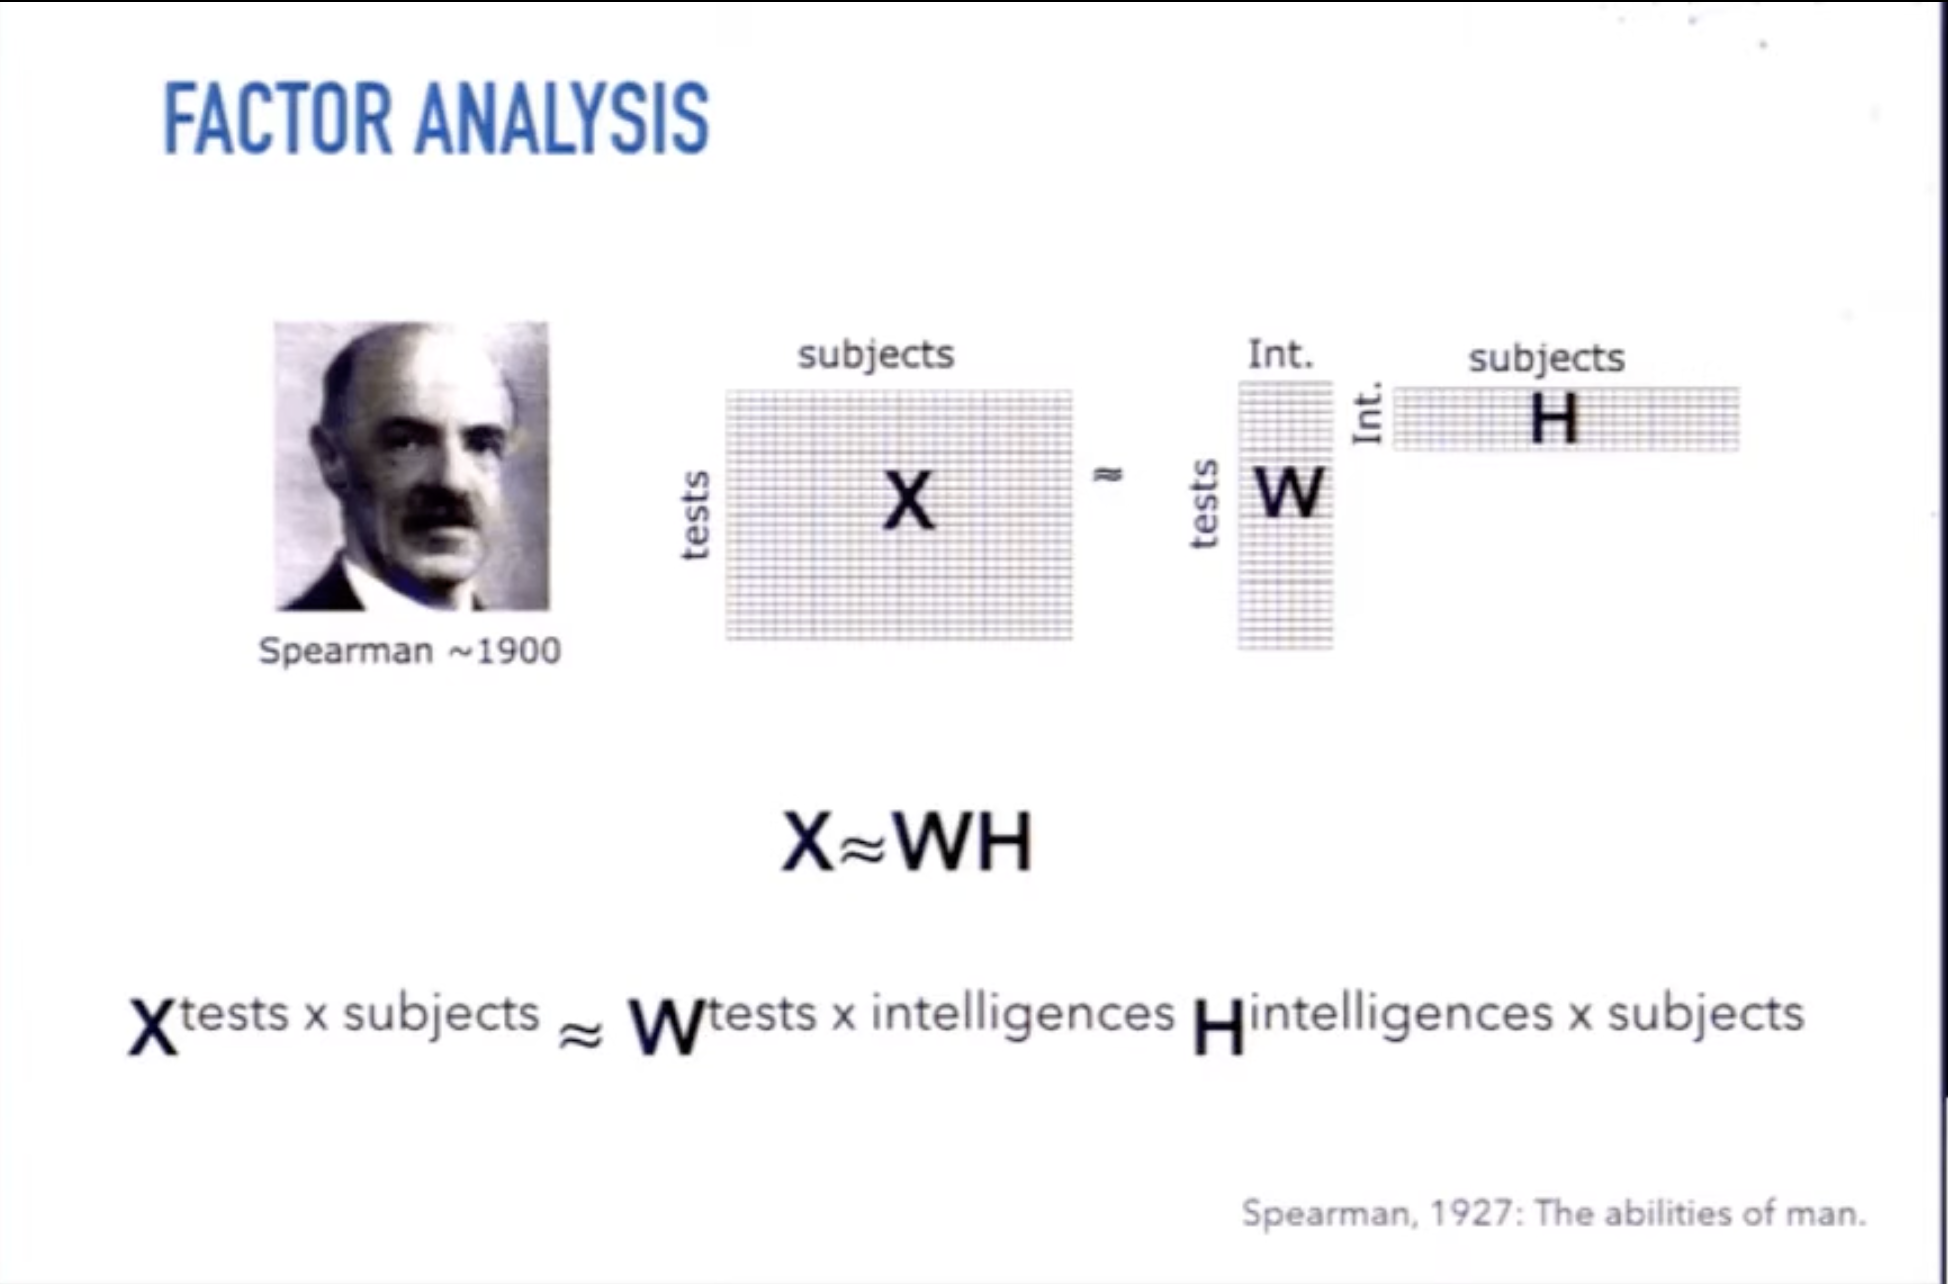

### UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction

In [ ]:
#conda install -c conda-forge umap-learn

In [ ]:
#pip install umap-learn

In [ ]:
# General
'''
import umap
mapper = umap.UMAP(random_state=42,n_components=5)
mapper.fit(timestep_product_store) 
UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)
     
#Inverse transforms
inv_transformed_points = mapper.inverse_transform(test_pts)
     '''

In [ ]:
def metrics_(orig,preds):
    MSE=mean_squared_error(y_true=orig,
                   y_pred=preds)
    MAE=mean_absolute_error(y_true=orig,
                   y_pred=preds)
    MSLE=mean_squared_log_error(y_true=np.abs(orig),
                   y_pred=np.abs(preds))
    metrics = dict()
    metrics['MSE']= MSE
    metrics['MAE']= MAE
    metrics['MSLE']= MSLE
    return metrics

In [ ]:
def normalize(y_train):  
    # Choose between standardization and MinMAx normalization
    scaler=StandardScaler()
    # Storing the fit object for later reference
    scaler=scaler.fit(y_train)
    # Generating the standardized values of X
    yhat=scaler.transform(y_train)
    return yhat, scaler

In [ ]:
import math
import umap
def split2(X,test_size=0.2,n_components=5):
    n=X.shape[0]
    m = timestep_product_store.shape[0]
    X_train=X[0:math.floor((1-test_size)*n)]
    X_test=X[math.floor((1-test_size)*n):n+1]
    
    y_train=timestep_product_store[0:math.floor((1-test_size)*m)]
    y_test=timestep_product_store[math.floor((1-test_size)*m):m+1]
    
    ## Normalisation 
    yhat, scaler= normalize(y_train)
    
    mapper = umap.UMAP(random_state=42,n_components=n_components)
    mapper.fit(yhat)
   
    Composantes_principales= mapper.transform(yhat)
    columns=['C'+str(i) for i in range(n_components)]
    y_train_transform=pd.DataFrame(data=Composantes_principales,columns=columns)
    
    return X_train,X_test,y_train,y_train_transform,y_test,scaler,mapper

In [ ]:
def eval_umap(n_components):
    # split the data and pca over train_set, we learn the transformation matrice
    X_train,X_test,y_train,y_train_transform,y_test,myscaler,mapper=split2(X,test_size=0.2,n_components=n_components)
    #transformation over the test_set
       ## Normalisation 
    yhat=myscaler.transform(y_test)
    ## umap over the test set normalized
    principal_components=mapper.transform(yhat)
    # transform test data back to its original space
    Train_preds=myscaler.inverse_transform(mapper.inverse_transform(y_train_transform))
    Test_preds=myscaler.inverse_transform(mapper.inverse_transform(principal_components))
    # calculate the errors
    metrics_hist1=metrics_(y_train,Train_preds)
    metrics_hist2=metrics_(y_test,Test_preds)
    return  metrics_hist1,metrics_hist2 

In [ ]:
def generate_inputs(df: pd.DataFrame) -> pd.DataFrame:
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    X= pd.concat([
    df['date'].dt.date,
    df['date'].dt.day,
    #df['date'].dt.month,
    df['date'].dt.weekday,
    df['date'].dt.weekofyear
                 ],axis=1).drop_duplicates()
    X.columns=['time','day','weekday','weekofyear']
    X=X.sort_values(by = 'time') 
    return X.reset_index()[['time','day','weekday','weekofyear']]

In [ ]:
X=generate_inputs(df.rename(columns={'time':'date'})).set_index('time')
X

#### Reconstruction error

In [ ]:
# split the data and pca over train_set, we learn the transformation matrice
X_train,X_test,y_train,y_train_transform,y_test,myscaler,mapper=split2(X,test_size=0.2,n_components=5)
#transformation over the test_set
## Normalisation 
yhat=myscaler.transform(y_test)
## umap over the test set normalized
principal_components=mapper.transform(yhat)
# transform test data back to its original space
Train_preds=myscaler.inverse_transform(mapper.inverse_transform(y_train_transform))
Test_preds=myscaler.inverse_transform(mapper.inverse_transform(principal_components))
# calculate the errors
metrics_hist1=metrics_(y_train,Train_preds)
metrics_hist2=metrics_(y_test,Test_preds)
metrics_hist1

In [ ]:
def lin_reg(n_components):
    X_train,X_test,y_train,y_train_transform,y_test,scaler,mapper=split2(X,test_size=0.2,n_components=n_components)
    # Multiple Linear Regression 
    RegModel = LinearRegression()

    # Printing all the parameters of Linear regression
    print(RegModel)

    # Creating the model on Training Data
    LREG=RegModel.fit(X_train,y_train_transform)
    prediction=LREG.predict(X_test)
    preds=scaler.inverse_transform(mapper.inverse_transform(prediction))
    # Measuring Goodness of fit in Training data
    #print('R2 Valuefor n_pca=: %i' % n_components ,metrics.r2_score(y_train_transform, LREG.predict(X_train)))


    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,LREG

In [ ]:
def xtremegb(n_components):
    X_train,X_test,y_train,y_train_transform,y_test,scaler,mapper=split2(X,test_size=0.2,n_components=n_components)
    RegModel=XGBRegressor(max_depth=3, 
                          learning_rate=0.1, 
                          n_estimators=1000, 
                          objective='reg:squarederror',
                          booster='gbtree')

    # Creating the model on Training Data
    XGB=RegModel.fit(X_train,y_train_transform)
    prediction=XGB.predict(X_test) 
    preds=scaler.inverse_transform(mapper.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    #print('R2 Value for n_pca=:%i' % n_pca,metrics.r2_score(y_train_transform, XGB.predict(X_train)))
    
    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,XGB

In [ ]:
# Random Forest (Bagging of multiple Decision Trees)  with GridSearch
def RandForest_Regressor(n_components):
    X_train,X_test,y_train,y_train_transform,y_test,scaler,mapper=split2(X,test_size=0.2,n_components=n_components)
    
    # Define Parameters
    max_depth=[2, 8, 16]
    n_estimators = [64, 100, 128]
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

    # Build the grid search
    dfrst = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
    
    # Creating the model on Training Data
    grid_results = grid.fit(X_train, y_train_transform)
    
    # Extract the best decision forest 
    best_clf = grid_results.best_estimator_
   
    # Printing all the parameters of Random Forest
    print(best_clf)

    prediction=best_clf.predict(X_test)
    
    ##inversion de pca et de la normalisation
    preds=scaler.inverse_transform(mapper.inverse_transform(prediction))

    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    #print('R2 Value for train_set and n_pca=: %i' % n_pca,metrics.r2_score(y_train_transform,  best_clf.predict(X_train)))
    #print('R2 Value for test_set and n_pca=: %i' % n_pca,metrics.r2_score(y_test, preds))
    
    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,  best_clf

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
# Support Vector Machines(SVM)
def Multi_svm(n_components):
    X_train,X_test,y_train,y_train_transform,y_test,scaler,mapper=split2(X,test_size=0.2,n_components=n_components)
    
    svregressor= svm.SVR(C=50, kernel='rbf', gamma=0.01) # LinearSVR() #
    
    mulregressor = MultiOutputRegressor(svregressor)
    # Printing all the parameters
    print(mulregressor)

    # Creating the model on Training Data
    SVM=mulregressor.fit(X_train,y_train_transform)
    prediction=SVM.predict(X_test)
    preds=scaler.inverse_transform(mapper.inverse_transform(prediction))
    
    # Measuring Goodness of fit in Training data 'MSE: %.3f' % MSE
    #print('R2 Value for n_pca=: %i' % n_pca,metrics.r2_score(y_train_transform, SVM.predict(X_train)))
    
    metrics_hist=metrics_(y_test,preds)
    return preds,metrics_hist #,SVM

In [ ]:
from collections import defaultdict
events = None
feat_dynamic_cols = None
#input_data1=input_data[['day','weekday','weekofyear']] #,'bank_holiday','holiday']]
range_n_components = [5] # ,10,20]
mon_dico = defaultdict(list)
model=['LinRegressor','Multi_svm','RFRegressor'] #,'XgBoost','FbProphet','DeepAR']
for n_components in range_n_components:
    preds1,metriq1=lin_reg(n_components)
    preds2,metriq2=Multi_svm(n_components)
    preds3,metriq3=RandForest_Regressor(n_components)
    #preds4,metriq4=xtremegb(n_components)
    #preds5,metriq5=FBprophet(input_data,timestep_product_store,n_components,events)
    #preds6,metriq6=DeepAR_Amazon(input_data,timestep_product_store,n_components,feat_dynamic_cols)
    
    
    dicts = (metriq1, metriq2,metriq3) #,metriq4,metriq5,metriq6) 
    for d in dicts: # you can list as many input dicts as you want here
        for key, value in d.items():
            mon_dico[key].append(value)
    mon_dico['Model'].extend(model)
    for j in range(len(model)):
        mon_dico['n_components'].append(n_components)

m=pd.DataFrame(mon_dico)
m

In [ ]:
mon_dico['MAE'].append(metrics_hist1['MAE'])
mon_dico['MSE'].append(metrics_hist1['MSE'])
mon_dico['MSLE'].append(metrics_hist1['MSLE'])
mon_dico['Model'].append('Rebuild_Error')
mon_dico['n_components'].append(5)

res=pd.DataFrame(mon_dico)
res=res.sort_values(by=['MSE','MAE','MSLE'], ascending=True).set_index('n_components')
res

### Interface SVM with scaler (todo: add self.mean() )

In [ ]:
import datetime
import io
import json
import math
import os
import time
import uuid
from abc import abstractmethod
from os.path import exists
from typing import Any

import numpy as np
import pandas as pd
import pytz
from pandas import Series, DataFrame
from pandas.core.generic import NDFrame
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import api_type
from api_type import Algorithms
from model_class import CustomModel
from parameters.env_param import env
from utils.gstorage import GStorage
from utils.manage_log import get_logger
from utils.utility_fct import psinfo, cross_product, execute_sql_query, get_table_sql

# from french_holidays import get_french_holiday_calendar

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn import metrics

import pickle


class MultiOutputSVM(CustomModel):
    def __init__(self):
        """
        :param name: algorithm name
        :param target: prediction target used (quantity/margin/turnover)
        :param precision: algorithm granularity ex: store_id, all, 3600 = 1 prediction per store and hour
        :param score: score to order algorithms
        """
        super().__init__(
            name=Algorithms.multioutputsvm,
            score=0,  # high score = high priority
            target=api_type.TargetEnum.quantity,
            precision=api_type.Precision(**{
                'store': 'store_id',
                'product': 'product_id',
                'customer': 'all',
                'timestep': 3600 * 24
            })
        )
        self.n_pca = 5
        self.scaler = None
        # self.pca = None  # Not Useful
        self.components = None
        self.model = None
        self.columns = None
        self.fit_date = None
        self.last_run_date = None

    def fit(self):
        """
        fit the model (get training data, preprocess data and fit the model)
        :return: None
        """
        # if self.refit():
        #    , load the model
        # else: #the code below
        self.fit_date = pytz.timezone('Europe/Paris').localize(datetime.datetime.now()).date()

        # Load the data
        demand, product_movements = self.load_data()

        # Preprocessing the data
        x, new_products, timestep_product_store = self.preprocessing(demand, product_movements)
        self.columns = timestep_product_store.columns

        # splitting the data
        x_train, x_test, y_train, y_test = self.splitting(x, timestep_product_store, 0.0)

        # Normalise the output train set
        self.scaler, yhat = self.standardization(y_train)

        # PCA over the output per product per store
        my_pca = PCA(n_components=self.n_pca)
        principal_component = my_pca.fit_transform(yhat)
        columns = [f'component_{i + 1}' for i in range(self.n_pca)]
        y_train = pd.DataFrame(data=principal_component, columns=columns)
        # self.pca = my_pca
        # calculate the components of the data matrix: Transformation Matrix.
        # array [n_components, n_features] in which each row corresponds to an eigenvector;
        # the order is that of the eigenvalues.
        components = my_pca.components_
        self.components = pd.DataFrame(components, columns=self.columns,
                                       index=[f'component_{i + 1}' for i in range(self.n_pca)])
        # En fait principal_component = yhat.dot(components.T)

        # Fit the model over the Principal component
        sv_regressor = svm.SVR(C=50, kernel='rbf', gamma=0.01)  # or LinearSVR() #
        mul_regressor = MultiOutputRegressor(sv_regressor)

        # Creating the model on Training Data
        self.model = mul_regressor.fit(x_train, y_train)
        # Make a test (if we consider split_size not egal to 0)
        # prediction = self.model.predict(x_test)
        # PCA and Standardization Inversion (Transform data back to its original space.)

        # "predict = self.scaler.mul(self.pca.inverse_transform(prediction)) # self.scaler.T.values.dot(prediction.dot(self.components))"

        # Element-wise multiplication
        # predict = self.scaler.T.values*prediction.dot(self.components) # or np.multiply(self.scaler.T.values, prediction.dot(self.components))
        # Measuring Goodness of fit in Testing data 'MSE: %.3f' % MSE
        # print('R2 Value or Coefficient of determination for n_pca=%i: ' % self.n_pca, metrics.r2_score(y_test, predict))
        # print(self.metrics_(y_test, predict))

        # Update for the news products

        # self.update_new_products_stores(new_products, timestep_product_store)
        self.update_new_products_stores_expo_smoothing(new_products, timestep_product_store)

        # Predict the components of products to come and in projects if they exist
        # That is just update the Matrix self.components and self.columns for the task of prediction
        all_store_prod = self._get_precision_col(psinfo.get_store_ids()['store_id'].tolist())
        tained_store_prod = self.components.T.reset_index()[['store_id', 'product_id']]
        # filter the products_stores not used during training.
        # join the two, keeping all of all_store_prod's indices
        joined = pd.merge(all_store_prod, tained_store_prod, on=['store_id', 'product_id'], how='left', indicator=True)
        tocome_project_products = joined.query("_merge=='left_only'").drop('_merge', axis=1)

        # tocome_project_products=all_store_prod[~(all_store_prod['store_id'].isin(tained_store_prod['store_id']) &
        #                                         all_store_prod['product_id'].isin(tained_store_prod['product_id']))]
        self.update_project_product(tocome_project_products)

    def update_new_products_stores(self, new_products, timestep_product_store):
        # 1st Method: Calling the Function for prediction over the news products (products in stores since less than 14 days)
        # Extract the real quantities over the last 14 days
        # Run a Multi Objective Optimisation or vector optimisation or multi criteria optimisation or
        # multi attribute optimisation or Pareto optimisation:
        # let's find the matrix X such that "predict \times X.T - real" is minimal,
        # just a Linear Regression
        # Since T (difference of times) is not identical for each product per stores, we are going to use a loop
        mse1 = 0
        k1 = 0
        # Definition of the coefficient alpha for exponential smoothing
        alpha = 0.85
        alpha_vector = alpha**(new_products.drop_duplicates(subset=['product_id','store_id']).set_index(['product_id','store_id'])['duration'])
        mse2 = 0
        # Exhibition of news products/stores ids
        arrays = [new_products['product_id'].values, new_products['store_id'].values]
        index = pd.MultiIndex.from_arrays(arrays).drop_duplicates().rename(names=['product_id', 'store_id'])
        # components for news products
        new_products_components = self.components[index]  # It is going to be updated with a parameter alpha
        end_datetime = (
            datetime.datetime.now(tz=pytz.timezone('Europe/Paris'))).date()  # .time() to point out the time,
        # for svm
        coefs1 = pd.DataFrame()
        # for pca
        coefs2 = pd.DataFrame()
        for t in range(1, new_products['duration'].max() + 1):
            dt = new_products[new_products['duration'] == t]
            if len(dt) > 0:
                start_datetime = (
                        datetime.datetime.now(tz=pytz.timezone('Europe/Paris')) - datetime.timedelta(days=t)).date()
                # 1st Method, with the model svm
                in_data = pd.date_range(start=start_datetime, end=end_datetime)
                in_data = pd.to_datetime(in_data).tz_localize(pytz.timezone('Europe/Paris'))
                in_data = pd.DataFrame(data=in_data, columns=['time']) - pd.Timedelta(days=1)
                new_sample_data_transform = self.generate_input(in_data)
                X = self.model.predict(new_sample_data_transform)
                X = pd.DataFrame(X, columns=[f'component_{i + 1}' for i in range(self.n_pca)],
                                 index=in_data['time'].dt.date)
                # Bad order of
                y = pd.pivot_table(dt, columns=['product_id', 'store_id'], index='time', values='product_count').fillna(
                    0)
                y2 = y.copy()
                y = y.merge(X, left_index=True, right_index=True)[y.columns]
                X = X.merge(y, left_index=True, right_index=True)[X.columns]
                ols = LinearRegression(fit_intercept=False)
                ols.fit(X, y)
                y_pred = ols.predict(X)
                coef = pd.DataFrame(ols.coef_, index=y.columns, columns=X.columns)
                coefs1 = pd.concat([coefs1, coef])
                mse1 += ((y - y_pred) * (y - y_pred)).sum().sum()
                k1 += y.shape[0] * y.shape[1]

                # 2nd Method, with pca transformation, pca.transform() or just .dot() with component
                # over the entire product per store, but on the t times steps.
                x_observe = timestep_product_store[-(t + 2):-1].dot(
                    self.components.T)  # timestep_product_store[-(t+1):].dot(self.components.T).values
                # verify shape (t,n_pca)
                x_observe = pd.DataFrame(x_observe.values, columns=[f'component_{i + 1}' for i in range(self.n_pca)],
                                         index=in_data['time'].dt.date)
                y2 = y2.merge(x_observe, left_index=True, right_index=True)[y2.columns]
                x_observe = x_observe.merge(y2, left_index=True, right_index=True)[x_observe.columns]
                # optimisation, that it find X of shape (n_pca,t) such that x_observe*X-y is minimal
                linear_model = LinearRegression(fit_intercept=False)
                # or use OLS(Ordinary Least Squares) optimizer, can also use GLS Generalized Least Squares or WLS
                linear_model.fit(x_observe, y2)
                y_pred2 = linear_model.predict(x_observe)
                coef2 = pd.DataFrame(linear_model.coef_, index=y.columns, columns=x_observe.columns)
                coefs2 = pd.concat([coefs2, coef2])
                # Evaluate the error of the residual = y_true - predictedValues
                mse2 += ((y2 - y_pred2) * (y2 - y_pred2)).sum().sum()

                # modify the vector alpha
                #duration = dt['duration'].values[0]
                #alpha_time_duration = pd.DataFrame(np.array([alpha for i in range(y.shape[1])]**duration), index=y.columns,columns=['alpha'])
                #alpha_vector = pd.concat([alpha_vector, alpha_time_duration])

        mse1 = mse1 / k1
        mse2 = mse2 / k1

        #     linear_model = sm.OLS(y, X)
        #     # OLS stands for Ordinary Least Squares, can also use GLS Generalized Least Squares or WLS
        #     results = linear_model.fit()
        #     param[product_id, store_id] = results.params.tolist()
        #
        #     # Evaluate the error of the residual = y_true - predictedValues
        #     mse1 += mean_squared_error(y_true=y,
        #                                y_pred=results.fittedvalues)

        rmse = [math.sqrt(mse1), math.sqrt(mse2)]
        # Transform Index into MultiIndex
        coefs1.index = pd.MultiIndex.from_tuples(coefs1.index, names=["product_id", "store_id"])
        coefs2.index = pd.MultiIndex.from_tuples(coefs2.index, names=["product_id", "store_id"])

        # put new_products_components in the true order of columns as in coefs.index
        new_products_components = new_products_components[coefs1.index]
        # put alpha_vector in the true order of index as in coefs.index
        alpha_vector = alpha_vector.T[coefs1.index].T
        # return coefs1, coefs2, index, new_products_components, error, alpha_vector

        # Correction of the PCA's Matrix over the news products and update using the best Methods

        new_products_components_update1 = (1 - alpha_vector).T * new_products_components + alpha_vector.T * coefs1.T
        new_products_components_update2 = (1 - alpha_vector).T * new_products_components + alpha_vector.T * coefs2.T

        # Select the best one based on a metric: the norm of the residuals
        if rmse[0] < rmse[1]:
            best_new_products_components_update = new_products_components_update1
        else:
            best_new_products_components_update = new_products_components_update2

        # Update the Transformation Matrix self.components, Merge ?
        # to delete duplicates due to products in a particular store with 2 different start_date (aberration), let's do
            best_new_products_components_update = best_new_products_components_update.T.reset_index().drop_duplicates(
                subset=['product_id', 'store_id'],
                keep='first', inplace=False).set_index(['product_id', 'store_id']).T
            # and then update
        self.components[best_new_products_components_update.columns] = best_new_products_components_update

        # update the scaler for the new product
        # delete eventually duplicates in alpha_vector
        alpha_vector = alpha_vector.reset_index().drop_duplicates(subset=['product_id', 'store_id'],
                                                                  keep='first', inplace=False).set_index(
            ['product_id', 'store_id'])
        # update
        scal = self.scaler.copy().T
        scal[index] = (1 - alpha_vector).T * self.scaler.T[index] + \
                      alpha_vector.T * np.sqrt(1 / (self.scaler.T[index].shape[1]) * self.scaler.T[index] ** 2)
        self.scaler = scal.T

    def update_new_products_stores_expo_smoothing(self, new_products, timestep_product_store):
        # 1st Method: Calling the Function for prediction over the news products (products in stores since less than 14 days)
        # Extract the real quantities over the last 14 days
        # Run a Multi Objective Optimisation or vector optimisation or multi criteria optimisation or
        # multi attribute optimisation or Pareto optimisation:
        # let's find the matrix X such that "predict \times X.T - real" is minimal,
        # just a Linear Regression
        # Since T (difference of times) is not identical for each product per stores, we are going to use a loop
        mse1 = 0
        mse2 = 0
        k1 = 0
        # Definition of the coefficient alpha for exponential smoothing
        alpha = 0.85
        alpha_vector = alpha ** (
        new_products.drop_duplicates(subset=['product_id', 'store_id']).set_index(['product_id', 'store_id'])[
            'duration'])
        # Exhibition of news products/stores ids
        arrays = [new_products['product_id'].values, new_products['store_id'].values]
        index = pd.MultiIndex.from_arrays(arrays).drop_duplicates().rename(names=['product_id', 'store_id'])
        # components for news products
        new_products_components = self.components[index]  # It is going to be updated with a parameter alpha
        end_datetime = (
            datetime.datetime.now(tz=pytz.timezone('Europe/Paris'))).date()  # .time() to point out the time,
        # for svm
        coefs1 = pd.DataFrame()
        # for pca
        coefs2 = pd.DataFrame()

        for t in range(1, new_products['duration'].max() + 1):
            dt = new_products[new_products['duration'] == t]
            if len(dt) > 0:
                start_datetime = (
                        datetime.datetime.now(tz=pytz.timezone('Europe/Paris')) - datetime.timedelta(days=t)).date()
                # 1st Method, with the model svm
                in_data = pd.date_range(start=start_datetime, end=end_datetime)
                in_data = pd.to_datetime(in_data).tz_localize(pytz.timezone('Europe/Paris'))
                in_data = pd.DataFrame(data=in_data, columns=['time']) - pd.Timedelta(days=1)
                new_sample_data_transform = self.generate_input(in_data)
                X = self.model.predict(new_sample_data_transform)
                X = pd.DataFrame(X, columns=[f'component_{i + 1}' for i in range(self.n_pca)],
                                 index=in_data['time'].dt.date)
                # Bad order of
                y = pd.pivot_table(dt, columns=['product_id', 'store_id'], index='time', values='product_count').fillna(
                    0)
                y2 = y.copy()
                y = y.merge(X, left_index=True, right_index=True)[y.columns]
                X = X.merge(y, left_index=True, right_index=True)[X.columns]
                ols = LinearRegression(fit_intercept=False)
                ols.fit(X, y)
                y_pred = ols.predict(X)
                coef = pd.DataFrame(ols.coef_, index=y.columns, columns=X.columns)
                coefs1 = pd.concat([coefs1, coef])
                mse1 += ((y - y_pred) * (y - y_pred)).sum().sum()
                k1 += y.shape[0] * y.shape[1]

                # 2nd Method, with pca transformation, pca.transform() or just .dot() with component
                # over the entire product per store, but on the t times steps.
                x_observe = timestep_product_store[-(t + 2):-1].dot(
                    self.components.T)  # timestep_product_store[-(t+1):].dot(self.components.T).values
                # verify shape (t,n_pca)
                x_observe = pd.DataFrame(x_observe.values, columns=[f'component_{i + 1}' for i in range(self.n_pca)],
                                         index=in_data['time'].dt.date)
                y2 = y2.merge(x_observe, left_index=True, right_index=True)[y2.columns]
                x_observe = x_observe.merge(y2, left_index=True, right_index=True)[x_observe.columns]
                # optimisation, that it find X of shape (n_pca,t) such that x_observe*X-y is minimal
                linear_model = LinearRegression(fit_intercept=False)
                # or use OLS(Ordinary Least Squares) optimizer, can also use GLS Generalized Least Squares or WLS
                linear_model.fit(x_observe, y2)
                y_pred2 = linear_model.predict(x_observe)
                coef2 = pd.DataFrame(linear_model.coef_, index=y.columns, columns=x_observe.columns)
                coefs2 = pd.concat([coefs2, coef2])
                # Evaluate the error of the residual = y_true - predictedValues
                mse2 += ((y2 - y_pred2) * (y2 - y_pred2)).sum().sum()

        mse1 = mse1 / k1
        mse2 = mse2 / k1

        #     linear_model = sm.OLS(y, X)
        #     # OLS stands for Ordinary Least Squares, can also use GLS Generalized Least Squares or WLS
        #     results = linear_model.fit()
        #     param[product_id, store_id] = results.params.tolist()
        #
        #     # Evaluate the error of the residual = y_true - predictedValues
        #     mse1 += mean_squared_error(y_true=y,
        #                                y_pred=results.fittedvalues)

        rmse = [math.sqrt(mse1), math.sqrt(mse2)]
        # Transform Index into MultiIndex
        coefs1.index = pd.MultiIndex.from_tuples(coefs1.index, names=["product_id", "store_id"])
        coefs2.index = pd.MultiIndex.from_tuples(coefs2.index, names=["product_id", "store_id"])

        # put alpha_vector in the true order of index as in coefs.index
        alpha_vector = alpha_vector.loc[coefs1.index]
        ##########
        active_components = self.components.drop(new_products_components, axis=1).T.reset_index()

        # Add the categories
        products_category = psinfo.get_product_ids()
        new_products_category = new_products.drop_duplicates(subset=['product_id', 'store_id']).merge(products_category,
                                                                                                      on='product_id')

        # Average over each of the n_pca components per category per store
        new_components_mean_category = \
            active_components.merge(products_category, on='product_id').groupby(['category', 'store_id'])[
                list(set(active_components.columns) - {'store_id', 'product_id'})].mean().reset_index()

        # Components for each new product per each store
        # And delete duplicate with regard to the column product_id
        new_products_components_category = new_components_mean_category.merge(new_products_category,
                                                                              on=['category', 'store_id'],
                                                                              how='right').drop(
            ['category', 'product_count', 'duration', 'time'], axis=1).set_index(
            ['product_id', 'store_id'])

        # Replace the nan (for the new categories in new products not in the categories of the actives products) by the mean
        new_products_components_category = new_products_components_category.fillna(new_products_components_category.mean())

        # put new_products_components_category in the true order of index as in coefs.index
        new_products_components_category = new_products_components_category.loc[coefs1.index]
        # Now update
        # Correction of the PCA's Matrix over the news products and update using the best Methods
        new_products_components_update1 = (1 - alpha_vector).T * new_products_components_category.T + alpha_vector.T * coefs1.T
        new_products_components_update2 = (1 - alpha_vector).T * new_products_components_category.T + alpha_vector.T * coefs2.T

        # Select the best one based on a metric: the norm of the residuals
        if rmse[0] < rmse[1]:
            best_new_products_components_update = new_products_components_update1
        else:
            best_new_products_components_update = new_products_components_update2

        # Update the Transformation Matrix self.components, Merge ?  # names = df.columns.value_counts() to count duplicates
        # names[names > 1]
        # to delete duplicates due to products in a particular store with 2 different start_date (aberration), let's do
        best_new_products_components_update = best_new_products_components_update.T.reset_index().drop_duplicates(subset=['product_id', 'store_id'],
                                                                            keep='first', inplace=False).set_index(['product_id', 'store_id']).T
        # and then update
        self.components[best_new_products_components_update.columns] = best_new_products_components_update

        # update the scaler for the new product
        # update the scaler Matrix on the category basis
        active_scaler = self.scaler.copy().drop(new_products_components.columns).reset_index()
        # Average over each of the std per category per store

        new_scaler_mean_category = np.sqrt((active_scaler.set_index(['store_id', 'product_id']) ** 2).reset_index()
                                           .merge(products_category, on='product_id').groupby(['category', 'store_id'])[
                                               list(set(active_scaler.columns) - {'store_id',
                                                                               'product_id'})].mean()).reset_index()
        # Scaler for each product to come per each store
        # And delete duplicate with regard to the column product_id
        new_products_scaler_category = new_scaler_mean_category.merge(new_products_category,
                                                                     on=['category', 'store_id'],
                                                                     how='right').drop(
            ['category', 'product_count', 'duration', 'time'], axis=1).set_index(
            ['product_id', 'store_id'])
        # Replace the nan (for the new products categories not in the categories of the active products) by the mean
        new_products_scaler_category = new_products_scaler_category.fillna(np.sqrt((new_products_scaler_category ** 2).mean()))
        ##########
        # put new_products_scaler_category in the true order of index as in index
        new_products_scaler_category = new_products_scaler_category.loc[index]
        # update
        # delete eventually duplicates in alpha_vector
        alpha_vector = alpha_vector.reset_index().drop_duplicates(subset=['product_id', 'store_id'],
                                                   keep='first', inplace=False).set_index(['product_id', 'store_id'])

        scal = self.scaler.copy().T
        scal[index] = (1 - alpha_vector).T * self.scaler.T[index] + \
                      alpha_vector.T * new_products_scaler_category.T
        self.scaler = scal.T

    def standardization(self, y_train):
        # Choose between standardization and MinMAx normalization
        # scaler = StandardScaler()
        # Storing the fit object for later reference
        # scaler = scaler.fit(y_train)
        # Generating the standardized values of X
        # yhat = scaler.transform(y_train)
        # std along the rows' axis
        scaler = y_train.std(axis=0)
        # Avoid having null numbers by replacing the std by 1 for no changes
        scaler = scaler.replace(0, 1)
        yhat = y_train.mul(1 / scaler)
        return pd.DataFrame(scaler), yhat

    def splitting(self, x: pd.DataFrame, table: pd.DataFrame, test_size=0.2):
        n = x.shape[0]
        m = table.shape[0]
        x_train = x[0:math.floor((1 - test_size) * n)]
        x_test = x[math.floor((1 - test_size) * n):n + 1]
        y_train = table[0:math.floor((1 - test_size) * m)]
        y_test = table[math.floor((1 - test_size) * m):m + 1]
        return x_train, x_test, y_train, y_test

    def preprocessing(self, df1: pd.DataFrame, df2: pd.DataFrame):
        df2['start_date'] = pd.to_datetime(df2['start_date'], utc=True).dt.tz_localize(None)
        df2['end_date'] = pd.to_datetime(df2['end_date'], utc=True).dt.tz_localize(None)

        # start since the 1st january 2022
        ref = datetime.datetime(2022, 1, 1)
        df2["start_date"] = df2["start_date"].apply(lambda x: max(x, ref))

        # index_names = df2[df2['end_date'] < ref].index
        # df2.drop(index_names, inplace=True)
        # for i in df2.index:
        #    if df2['start_date'][i] < ref:
        #        df2['start_date'][i] = ref

        # Create intermediates Dates over the presence of products in the different stores
        df2['time'] = df2.apply(lambda x: pd.date_range(x.start_date, x.end_date), axis=1)
        df2 = df2.explode('time').reset_index(drop=True)
        df2['time'] = df2['time'].dt.date

        # Put the dates of df1 in datetime format (from timestamp, be cautious)
        df1['time'] = pd.to_datetime(df1.time).dt.date
        df = df1.merge(df2, how='right', on=['time', 'store_id', 'product_id']).fillna({'product_count': 0})
        df = df.dropna()

        # selection of news products (products in stores since less than 14 days)
        new_products = df[df['start_date'] >= datetime.datetime.now() - datetime.timedelta(days=14)]
        # Generate the columns of duration for each of these products per store
        new_products.loc[:, 'duration'] = new_products.apply(lambda x: (datetime.datetime.now() - x.start_date).days,
                                                             axis=1)  # td1.days : le nombre de jours d'une timedelta

        # Transform into sup triangular matrix
        new_products = new_products.sort_values(by=['duration'], ascending=False)  # tri par ordre décroisant

        # Delete unnecessary columns
        new_products = new_products.drop(columns=['start_date', 'end_date'])[
            new_products.duration > 0]  # la durée T dois etre moins supérieur à 0 strictement ?

        df.drop(columns=['start_date', 'end_date'])  # , axis=1)
        # df.drop(df.loc[:, 'start_date ':'end_date '].columns, axis = 1)

        # Let's create a matrix with one row per time step and one column per product per store
        timestep_product_store = pd.pivot_table(df, values='product_count', index='time',
                                                columns=['product_id', 'store_id'],
                                                aggfunc=np.sum)  # fill_value !=0 here
        # fillna() On = 'average quantity of each product over the all data' ie Matrix completion
        # tab = df[['product_id', 'store_id', 'product_count']].groupby(['product_id', 'store_id']).mean()
        tab = timestep_product_store.mean()
        timestep_product_store = timestep_product_store.fillna(tab)

        # Pre-process the input data
        input_data = self.generate_input(df)
        return input_data, new_products, timestep_product_store

    def generate_input(self, df: pd.DataFrame) -> pd.DataFrame:
        df['time'] = pd.to_datetime(df.time, format='%Y-%m-%d')
        input_data = pd.concat([
            df['time'].dt.date,
            df['time'].dt.day,
            # df['time'].dt.month,
            df['time'].dt.weekday,
            df['time'].dt.isocalendar().week,
        ], axis=1).drop_duplicates()
        input_data.columns = ['time', 'day', 'weekday', 'weekofyear']
        input_data = input_data.sort_values(by='time')
        return input_data[['time', 'day', 'weekday', 'weekofyear']].set_index(
            'time')  # or input_data.reset_index()[['day', 'weekday', 'weekofyear']]

    def load_data(self):
        sql_query1 = f"""
            select 
                product_id,
                store_id,
                date(created_at) as time,
                - sum(product_count) as product_count
            from 
                api_storebox.inventory_movements_view imv
            where 
                bucket= 'stock' and reason='sales_order' and 
                date(created_at) >= date('2022-01-01') and 
                date(created_at) < date(now())
            group by 
                product_id,
                store_id,
                date(created_at) 
        """
        df1 = get_table_sql(sql_query1, table_name='demand')
        if len(df1) == 0:
            df1 = pd.DataFrame(columns=['product_id', 'store_id', 'time', 'product_count'])
        sql_query2 = f"""
            select 
                store_id,
                product_id,
                start_date,
                end_date
            from 
                api_storebox.product_movements 
            where 
                end_date>= date('2022-01-01') 
        """
        df2 = get_table_sql(sql_query2, table_name='product_movements')
        if len(df2) == 0:
            df2 = pd.DataFrame(columns=['store_id', 'product_id', 'start_date', 'end_date'])
        return df1, df2

    def predict(self, X):
        """
        predit data using current model
        :param X:pd.DataFrame: 3 cols : 'time', 'store_id', 'product_id' - one row per (timestep x store_id x product_id)   ## time==date
        :return: pd.DataFrame: 4 cols : 'time', 'store_id', 'product_id', self.target
        """

        # X['time'] = pd.to_datetime(X['time'], utc=True).dt.tz_convert('Europe/Paris')
        # store_ids = list(X['store_id'].unique())
        # InputData being a sequence of date
        input_data = X
        data_transform = self.generate_input(input_data)
        # Generating Predictions
        predict = self.model.predict(data_transform)
        # PCA and Standardization Inversion (Transform data back to its original space.)

        # En fait self.pca.inverse_transform(prediction)=predict.dot(self.components.T)^_1 : np. linalg. inv(components.T) =components car Matrice Orthogonale
        # prediction1 = self.scaler.inverse_transform(self.pca.inverse_transform(predict)) is essentially done by the line code below
        # prediction = self.scaler.inverse_transform(predict.dot(self.components))

        # decomend to predict over all the product_stores
        # prediction = np.multiply(self.scaler.T.values, predict.dot(self.components))
        # Let's consider only those from X we are interested in.
        sp = X[['product_id', 'store_id']].drop_duplicates()
        prediction = np.multiply(self.scaler.loc[pd.MultiIndex.from_frame(sp)].T.values,
                                 predict.dot(self.components.T.loc[pd.MultiIndex.from_frame(sp)].T))

        # Transform to DataFrame
        # decomend to predict over all the product_stores
        # prediction = pd.DataFrame(data=prediction, columns=self.components.columns, index=data_transform.index) #columns=multiindex or columns=self.columns
        # for just the X product_stores,
        prediction = pd.DataFrame(data=prediction,
                                  columns=self.components.T.loc[pd.MultiIndex.from_frame(sp)].T.columns,
                                  index=data_transform.index)

        # inverse operation of pivot_table()
        prediction = prediction.stack([0, 1]).reset_index().rename({0: self.target.value}, axis=1)

        # apply relu function to prediction = product_count
        prediction[self.target.value] = prediction[self.target.value].clip(lower=0)
        prediction['time'] = prediction.time.astype('datetime64[ns, Europe/Paris]')
        prediction_result = prediction.drop_duplicates(['time', 'store_id', 'product_id']).merge(X,
                                                                                                 on=['time', 'store_id',
                                                                                                     'product_id'],
                                                                                                 how='right')
        return prediction_result[['time', 'store_id', 'product_id', self.target.value]]

    def update_project_product(self, tocome_project_products):
        """
           Mean over categories
        """
        # Exhibition of projects news products/stores ids:

        # project_products = get_table_sql("""
        # select distinct sv.store_id,mpm.product_id
        # from google_sheets.merch_product_movements mpm
        # join api_storebox.stores_view sv
        # using (cluster)
        # where start_date >= now()-interval '1week'
        # """, table_name='to_come')

        new_components = self.components.copy()
        new_components = new_components.T.reset_index()

        # Add the categories
        products_category = psinfo.get_product_ids()
        project_products_category = tocome_project_products.merge(products_category, on='product_id')

        # Average over each of the n_pca components per category per store
        new_components_mean_category = \
            new_components.merge(products_category, on='product_id').groupby(['category', 'store_id'])[
                list(set(new_components.columns) - {'store_id', 'product_id'})].mean().reset_index()

        # Components for each product to come per each store
        # And delete duplicate with regard to the column product_id
        new_project_components_category = new_components_mean_category.merge(project_products_category,
                                                                             on=['category', 'store_id'],
                                                                             how='right').drop(
            ['category'], axis=1).set_index(
            ['product_id', 'store_id'])
        # Replace the nan (for the new categories not in the categories of the training set) by the mean
        new_project_components_category = new_project_components_category.fillna(new_project_components_category.mean())
        # Concatenate over the columns
        tmp = self.components.T
        tmp = tmp.drop(new_project_components_category.index, errors='ignore')
        # tmp = new_project_components_category.drop(tmp.index, errors='ignore') ?
        tmp = pd.concat([tmp, new_project_components_category])
        self.components = tmp.T

        # update the columns
        self.columns = pd.MultiIndex.from_frame(pd.concat([pd.DataFrame(self.columns),
                                                           pd.DataFrame(new_project_components_category.index)
                                                           ]).drop_duplicates())

        # update the scaler Matrix on the category basis
        new_scaler = self.scaler.copy().reset_index()
        # Average over each of the std per category per store

        new_scaler_mean_category = np.sqrt((new_scaler.set_index(['store_id', 'product_id'])**2).reset_index()
                                           .merge(products_category, on='product_id').groupby(['category', 'store_id'])[
                list(set(new_scaler.columns) - {'store_id', 'product_id'})].mean()).reset_index()
        # Scaler for each product to come per each store
        # And delete duplicate with regard to the column product_id
        new_project_scaler_category = new_scaler_mean_category.merge(project_products_category,
                                                                     on=['category', 'store_id'],
                                                                     how='right').drop(
            ['category'], axis=1).set_index(
            ['product_id', 'store_id'])
        # Replace the nan (for the new categories not in the categories of the training set) by the mean
        new_project_scaler_category = new_project_scaler_category.fillna(np.sqrt((new_project_scaler_category**2).mean()))
        # Concatenate over the columns
        tmp2 = self.scaler
        tmp2 = new_project_scaler_category.drop(tmp2.index, errors='ignore')

        self.scaler = pd.concat([self.scaler, tmp2])

    def save(self):
        """
        :return: dict of file_name:file of type str:io.BytesIO to be saved
        """
        files = {}
        final_svm_model = self.model
        file_write_stream = io.BytesIO()
        pickle.dump(final_svm_model, file_write_stream)
        file_write_stream.seek(0)
        files['model'] = file_write_stream

        final_scaler = self.scaler
        file_write_stream = io.BytesIO()
        pickle.dump(final_scaler, file_write_stream)
        file_write_stream.seek(0)
        files['scaler'] = file_write_stream

        final_n_pca = self.n_pca
        file_write_stream = io.BytesIO()
        pickle.dump(final_n_pca, file_write_stream)
        file_write_stream.seek(0)
        files['n_pca'] = file_write_stream

        final_columns = self.columns
        file_write_stream = io.BytesIO()
        pickle.dump(final_columns, file_write_stream)
        file_write_stream.seek(0)
        files['columns'] = file_write_stream

        final_components = self.components
        file_write_stream = io.BytesIO()
        pickle.dump(final_components, file_write_stream)
        file_write_stream.seek(0)
        files['components'] = file_write_stream

        fit_date = self.fit_date
        file_write_stream = io.BytesIO()
        pickle.dump(fit_date, file_write_stream)
        file_write_stream.seek(0)
        files['fit_date'] = file_write_stream

        return files

    def load(self, files):
        """
        :param files: dict of file_name:files
        :return:
        """
        """if self.refit() != False:
            self.fit()
        else:"""
        self.model = pickle.load(files['model'])
        self.scaler = pickle.load(files['scaler'])
        self.n_pca = pickle.load(files['n_pca'])
        self.columns = pickle.load(files['columns'])
        self.components = pickle.load(files['components'])
        self.fit_date = pickle.load(files['fit_date'])

    def refit(self) -> bool:
        """
        should the algorithms be refitted ?
        :return: bool
        """
        if self.fit_date == pytz.timezone('Europe/Paris').localize(datetime.datetime.now()).date():
            return False
        else:
            return True

    def validate_new_model(self) -> bool:
        """
        is the new algorithm better than previous one ?
        :return: bool
        """
        # supposons qu'il ya toujours entrainement avant de tester la validation
        # Mettre un attribut loss,
        # ré-évaluer automatiquement ses prévisions après les avoir comparer à la réalité pour intégrer les écarts éventuellement constaté
        # comparer les deux loss et valider le model de plus faible loss,
        return True

    # For test in case we set text_size not equal to zero
    def metrics_(self, orig, prediction):
        mse = mean_squared_error(y_true=orig,
                                 y_pred=prediction)
        mae = mean_absolute_error(y_true=orig,
                                  y_pred=prediction)
        ms_le = mean_squared_log_error(y_true=np.abs(orig),
                                       y_pred=np.abs(prediction))
        metric = dict()
        metric['MSE'] = mse
        metric['MAE'] = mae
        metric['MSLE'] = ms_le
        return metric


if __name__ == '__main__':
    model = MultiOutputSVM()
    model.fit()
    # Calling the functions for some applications
    start_date = datetime.datetime(2022, 8, 25)
    end_date = datetime.datetime(2022, 8, 28)
    data = pd.date_range(start=start_date, end=end_date)
    data = pd.to_datetime(data).tz_localize(pytz.timezone('Europe/Paris'))
    NewSampleData = pd.DataFrame(data=data,
                                 columns=['time'])
    NewSampleData['product_id'] = '5f8ee80289bc4b000417840f'
    NewSampleData['store_id'] = '5f1198de8746ae00042869ba'

    # Calling the Function for prediction
    d1 = model.predict(NewSampleData)
    # tester le load() et le save()
    model2 = MultiOutputSVM()
    model2.load(model.save())
    d2 = model2.predict(NewSampleData)
    assert(d1.equals(d2))
    print(d1.equals(d2))

    model3 = MultiOutputSVM()
    model.save_wrapper()
    model3.load_wrapper()
    d3 = model2.predict(NewSampleData)
    assert (d1.equals(d3))
    print(d1.equals(d3))
